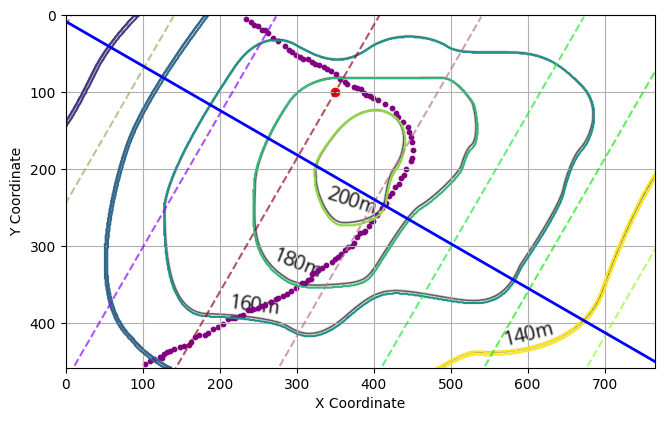

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pickle
import pandas as pd

def parse_azimuth(direction):
    """주향을 방위각(degrees)으로 변환하는 함수"""
    direction = direction.upper().strip()
    if "N" in direction:
        base_azimuth = 0
        if "E" in direction:
            angle = int(direction.replace("N", "").replace("E", ""))
            return base_azimuth + angle
        elif "W" in direction:
            angle = int(direction.replace("N", "").replace("W", ""))
            return 360 - angle
    elif "S" in direction:
        base_azimuth = 180
        if "E" in direction:
            angle = int(direction.replace("S", "").replace("E", ""))
            return base_azimuth - angle
        elif "W" in direction:
            angle = int(direction.replace("S", "").replace("W", ""))
            return base_azimuth + angle
    raise ValueError("유효하지 않은 주향입니다. 예: N10E, S45W 등")

# 제공된 데이터를 기반으로 한 그래프 그리기
def plot_geological_boundary_and_features_with_image(img_path, contour_data, contour_heights, strike_lines, intersections, mineral_location, strike_direction, points):
    # 이미지 불러오기
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width = img.shape[0], img.shape[1]

    # 주향 방위각 계산 및 수직 방향 설정
    azimuth = parse_azimuth(strike_direction)
    perpendicular_azimuth = (azimuth) % 360

    # 이미지 중심을 기준으로 단순히 90도 회전하여 수직선 그리기
    center_x = img_width / 2
    center_y = img_height / 2

    # 수직 방향의 기울기 계산
    theta = math.radians(perpendicular_azimuth)
    line_length = max(img_width, img_height)  # 충분히 긴 선 길이 설정

    # 수직선의 시작과 끝 계산
    x_start = center_x - line_length * math.cos(theta)
    y_start = center_y - line_length * math.sin(theta)
    x_end = center_x + line_length * math.cos(theta)
    y_end = center_y + line_length * math.sin(theta)

    # 원본 이미지 위에 플롯
    plt.figure(figsize=(img_width / 100, img_height / 100))  # 이미지 크기에 맞춰 그래프 크기 설정
    plt.imshow(img_rgb)

    # 등고선 플롯
    contour_groups = contour_data.groupby('Contour')
    for contour_num, group in contour_groups:
        x_coords = group['X'].values
        y_coords = group['Y'].values
        color = plt.cm.viridis(contour_num / len(contour_heights))
        plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} (Height: {contour_heights.get(contour_num, "N/A")})')

    # 주향선 플롯
    for idx, (x_line, y_line, height) in enumerate(strike_lines):
        plt.plot(x_line, y_line, linestyle='--', alpha=0.7, label=f'Strike Line at {height}m', color=np.random.rand(3,))

    # 교차점 플롯
    for contour_num, x, y in intersections:
        plt.scatter(x, y, color='green', s=50, edgecolor='black', label='Intersection')

    # 광물 위치 플롯
    m_x, m_y = mineral_location
    plt.scatter(m_x, m_y, color='red', label='Mineral Location')

    # 지층 경계선의 점들을 산점도로 플롯
    points_x, points_y = zip(*points)
    plt.scatter(points_x, points_y, color='purple', s=10, label='Geological Boundary Points')

    # XY 선 플롯 (주향에 단순히 90도 회전)
    plt.plot([x_start, x_end], [y_start, y_end], color='blue', linestyle='-', linewidth=2, label='Perpendicular XY Line')

    # 그래프 범위 설정 (이미지 크기에 맞춤)
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전

    # 기타 설정
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    #plt.legend()
    plt.show()


# 저장된 파일 불러오기
def load_variables_from_files():
    # contour_data를 CSV 파일에서 불러오기
    contour_data = pd.read_csv('past_contour_data.csv')

    # contour_heights, strike_lines, intersections, points를 pickle에서 불러오기
    with open('past_contour_heights.pkl', 'rb') as f:
        contour_heights = pickle.load(f)

    with open('past_strike_lines.pkl', 'rb') as f:
        strike_lines = pickle.load(f)

    with open('intersections.pkl', 'rb') as f:
        intersections = pickle.load(f)

    with open('past_points.pkl', 'rb') as f:
        points = pickle.load(f)

    return contour_data, contour_heights, strike_lines, intersections, points

# 불러온 데이터를 그래프 함수에서 사용
contour_data, contour_heights, strike_lines, intersections, points = load_variables_from_files()

# 이미지 경로 설정 및 광물 위치 예시
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png'
mineral_location = (350, 100)

# 이미지와 함께 그래프 그리기 (주향 방향 정보 포함)
plot_geological_boundary_and_features_with_image(img_path=r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png',
                                                 contour_data=contour_data,
                                                 contour_heights=contour_heights,
                                                 strike_lines=strike_lines,
                                                 intersections=intersections,
                                                 mineral_location=mineral_location,
                                                 strike_direction="N30E",  # 주향 정보 입력
                                                 points=points)  # 지층 경계선의 점들 입력
